In [23]:
from typing import TYPE_CHECKING, Callable, Optional, Union
from typing import Any, Optional, Tuple, Union
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append("/home/tangyao/ovam/ovam")
sys.path.append("/home/tangyao/ovam/ovam/utils")
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
from PIL import Image
# Import the OVAM library
from ovam import StableDiffusionHooker # actually is StableDiffusionHookerSA
from ovam.utils import set_seed, get_device
from ovam.optimize import optimize_embedding
from ovam.utils.dcrf import densecrf
# from diffusers import StableDiffusionPipeline
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, DDPMScheduler, StableDiffusionPipeline, UNet2DConditionModel

if TYPE_CHECKING:
    from ..base.daam_module import DAAMModule



# -----------------------------Prepare model-----------------------------------
# args = parse_args()
pretrained_model_name_or_path="/home/data/huggingface/Pretrained_model_files/sd_v1-4"
pre_unet_path="/home/tangyao/BadT2I/laion_pixel_boya_unet_bsz4_step4_sks"
revision=None
vae = AutoencoderKL.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="vae",
        revision=revision,
        low_cpu_mem_usage=False,
    )
text_encoder = CLIPTextModel.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="text_encoder",
        revision=revision,
        low_cpu_mem_usage=True,
    )
tokenizer = CLIPTokenizer.from_pretrained(
        pretrained_model_name_or_path, subfolder="tokenizer", revision=revision, low_cpu_mem_usage=True,
    )
noise_scheduler = DDPMScheduler.from_pretrained(pretrained_model_name_or_path, subfolder="scheduler",
                                                    low_cpu_mem_usage=False, )
unet = UNet2DConditionModel.from_pretrained(
        pre_unet_path,
        revision=revision,
        low_cpu_mem_usage=False,
    )
# Unet2D conditionModel 可以直接加timestep
pipe = StableDiffusionPipeline.from_pretrained(
            pretrained_model_name_or_path,
            text_encoder=text_encoder,
            vae=vae,
            unet=unet,
            revision=revision,
            low_cpu_mem_usage=False,
        )

device = get_device()
pipe = pipe.to(device)



The config attributes {'dropout': 0.0} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.
Loading pipeline components...: 100%|██████████| 7/7 [00:02<00:00,  2.82it/s]


In [24]:
def normalize(sa):
    sa = (sa - sa.min()) / (sa.max() - sa.min())
    return sa

def encode_text(
        text: str,
        device,
        tokenizer,
        text_encoder,
        padding=False,
    ) -> "torch.Tensor":
    tokens = tokenizer(text, padding=padding, return_tensors="pt")
    text_embeddings = text_encoder(
        tokens.input_ids.to(device), attention_mask=tokens.attention_mask.to(device)
    )
    return text_embeddings[0]

def encode_text2(
        text: str,
        device,
        tokenizer,
        text_encoder,
        padding=False,
    ) -> "torch.Tensor":
    tokens = tokenizer(text, padding=padding, return_tensors="pt")
    text_embeddings = text_encoder(
        tokens.input_ids.to(device), attention_mask=tokens.attention_mask.to(device)
    )
    print(text_embeddings[0].shape)
    
    return text_embeddings[0]


In [25]:

# Copied from transformers.models.bart.modeling_bart._make_causal_mask
def _make_causal_mask(
    input_ids_shape: torch.Size, dtype: torch.dtype, device: torch.device, past_key_values_length: int = 0
):
    """
    Make causal mask used for bi-directional self-attention.
    """
    bsz, tgt_len = input_ids_shape
    mask = torch.full((tgt_len, tgt_len), torch.tensor(torch.finfo(dtype).min, device=device), device=device)
    mask_cond = torch.arange(mask.size(-1), device=device)
    mask.masked_fill_(mask_cond < (mask_cond + 1).view(mask.size(-1), 1), 0)
    mask = mask.to(dtype)

    if past_key_values_length > 0:
        mask = torch.cat([torch.zeros(tgt_len, past_key_values_length, dtype=dtype, device=device), mask], dim=-1)
    return mask[None, None, :, :].expand(bsz, 1, tgt_len, tgt_len + past_key_values_length)

# Copied from transformers.models.bart.modeling_bart._expand_mask
def _expand_mask(mask: torch.Tensor, dtype: torch.dtype, tgt_len: Optional[int] = None):
    """
    Expands attention_mask from `[bsz, seq_len]` to `[bsz, 1, tgt_seq_len, src_seq_len]`.
    """
    bsz, src_len = mask.size()
    tgt_len = tgt_len if tgt_len is not None else src_len

    expanded_mask = mask[:, None, None, :].expand(bsz, 1, tgt_len, src_len).to(dtype)

    inverted_mask = 1.0 - expanded_mask

    return inverted_mask.masked_fill(inverted_mask.to(torch.bool), torch.finfo(dtype).min)


In [26]:
from transformers.modeling_outputs import BaseModelOutputWithPooling

class Embedding(nn.Module):
    def __init__(self, 
        max_position_embeddings=77,
        ):
        super().__init__()
        self.token_embedding = pipe.text_encoder.get_input_embeddings()
        self.position_embedding = pipe.text_encoder.text_model.embeddings.position_embedding
        self.register_buffer("position_ids", torch.arange(max_position_embeddings).expand((1, -1)))

    def trans_forward(
        self,
        device,
        text_encoder,
        trigger_ebd: Optional[torch.Tensor]=  None,
        text_inputs: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
        hidden_size=768,
        vocab_size=49408,
        max_position_embeddings=77,
        layer_norm_eps=1e-5,
    ) -> Union[Tuple, BaseModelOutputWithPooling]:

        return_dict = return_dict if return_dict is not None else text_encoder.config.use_return_dict
        
        text_input_ids = text_inputs
        attention_mask = None # text_inputs.attention_mask.to(device)
        
        # =============================== TextTransformer ====================================
        add_size =  torch.randn(1, 1).expand(text_input_ids.size(0), -1).to(device)
        tri_input_shape = torch.cat((text_input_ids, add_size), dim=1).size()

        input_shape = text_input_ids.size()
        text_input_ids = text_input_ids.view(-1, input_shape[-1])

        # ================================ self.embedding ====================================
        inputs_embeds = self.token_embedding(text_input_ids)

        tiled_tensor = trigger_ebd.expand(inputs_embeds.size(0), -1, -1)
        cat1_embeds = torch.cat((inputs_embeds[:, :1, :], tiled_tensor), dim=1) # sot
        cat_embeds = torch.cat((cat1_embeds, inputs_embeds[:, 1:, :]), dim=1)

        seq_length = (text_input_ids.shape[-1]+1) if text_input_ids is not None else inputs_embeds.shape[-2]

        if position_ids is None:
            position_ids = self.position_ids[:, :seq_length].to(device)

        position_embeddings = self.position_embedding(position_ids)
        embeddings = cat_embeds + position_embeddings.to(device)

        hidden_states = embeddings
        # ====================================================================

        # CLIP's text model uses causal mask, prepare it here.
        # https://github.com/openai/CLIP/blob/cfcffb90e69f37bf2ff1e988237a0fbe41f33c04/clip/model.py#L324

        causal_attention_mask = _make_causal_mask(tri_input_shape, hidden_states.dtype, device=hidden_states.device)
        # expand attention_mask
        if attention_mask is not None:
            # [bsz, seq_len] -> [bsz, 1, tgt_seq_len, src_seq_len]
            attention_mask = _expand_mask(attention_mask, hidden_states.dtype)
        
        encoder_outputs = text_encoder.text_model.encoder(
            inputs_embeds=hidden_states,
            attention_mask=attention_mask,
            causal_attention_mask=causal_attention_mask.to(device),
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        last_hidden_state = encoder_outputs[0]
        last_hidden_state = text_encoder.text_model.final_layer_norm(last_hidden_state)

        # text_embeds.shape = [batch_size, sequence_length, transformer.width]
        # take features from the eot embedding (eot_token is the highest number in each sequence)
        # casting to torch.int for onnx compatibility: argmax doesn't support int64 inputs with opset 14
        pooled_output = last_hidden_state[
            torch.arange(last_hidden_state.shape[0], device=last_hidden_state.device),
            text_input_ids.to(dtype=torch.int, device=last_hidden_state.device).argmax(dim=-1),
        ]

        if not return_dict:
            return (last_hidden_state, pooled_output) + encoder_outputs[1:]

        return BaseModelOutputWithPooling(
            last_hidden_state=last_hidden_state,
            pooler_output=pooled_output,
            hidden_states=encoder_outputs.hidden_states,
            attentions=encoder_outputs.attentions,
        )

In [27]:
from transformers.modeling_outputs import BaseModelOutputWithPooling

class Embedding1(nn.Module):
    def __init__(self, 
        max_position_embeddings=77,
        layer_norm_eps=1e-5,
        hidden_size=768,
        vocab_size=49408,
        ):
        super().__init__()
        self.token_embedding = pipe.text_encoder.get_input_embeddings()
        self.position_embedding = pipe.text_encoder.text_model.embeddings.position_embedding
        self.register_buffer("position_ids", torch.arange(max_position_embeddings).expand((1, -1)))

    def trans_forward(
        self,
        device,
        text_encoder,
        trigger_ebd: Optional[torch.Tensor]=  None,
        text_inputs: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
        hidden_size=768,
        vocab_size=49408,
        max_position_embeddings=77,
        layer_norm_eps=1e-5,
    ) -> Union[Tuple, BaseModelOutputWithPooling]:

        return_dict = return_dict if return_dict is not None else text_encoder.config.use_return_dict
        
        text_input_ids = text_inputs.input_ids
        attention_mask = None # text_inputs.attention_mask.to(device)
        
        # =============================== TextTransformer ====================================
        input_shape = text_input_ids.size()
        text_input_ids = text_input_ids.view(-1, input_shape[-1])
        
        # ================================ self.embedding ====================================
        inputs_embeds = self.token_embedding(text_input_ids)
        seq_length = text_input_ids.shape[-1] if text_input_ids is not None else inputs_embeds.shape[-2]
        print("========================")
        print(inputs_embeds)
        if position_ids is None:
            position_ids = self.position_ids[:, :seq_length].to(device)

        position_embeddings = self.position_embedding(position_ids)
        embeddings = inputs_embeds + position_embeddings.to(device)

        hidden_states = embeddings
        # ====================================================================

        # CLIP's text model uses causal mask, prepare it here.
        # https://github.com/openai/CLIP/blob/cfcffb90e69f37bf2ff1e988237a0fbe41f33c04/clip/model.py#L324
        causal_attention_mask = _make_causal_mask(input_shape, hidden_states.dtype, device=hidden_states.device)
        # expand attention_mask
        if attention_mask is not None:
            # [bsz, seq_len] -> [bsz, 1, tgt_seq_len, src_seq_len]
            attention_mask = _expand_mask(attention_mask, hidden_states.dtype)
        
        encoder_outputs = text_encoder.text_model.encoder(
            inputs_embeds=hidden_states,
            attention_mask=attention_mask,
            causal_attention_mask=causal_attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        print(encoder_outputs)

        last_hidden_state = encoder_outputs[0]
        last_hidden_state = text_encoder.text_model.final_layer_norm(last_hidden_state)
        # last_hidden_state = self.final_layer_norm(last_hidden_state)

        # text_embeds.shape = [batch_size, sequence_length, transformer.width]
        # take features from the eot embedding (eot_token is the highest number in each sequence)
        # casting to torch.int for onnx compatibility: argmax doesn't support int64 inputs with opset 14
        pooled_output = last_hidden_state[
            torch.arange(last_hidden_state.shape[0], device=last_hidden_state.device),
            text_input_ids.to(dtype=torch.int, device=last_hidden_state.device).argmax(dim=-1),
        ]

        if not return_dict:
            return (last_hidden_state, pooled_output) + encoder_outputs[1:]

        return BaseModelOutputWithPooling(
            last_hidden_state=last_hidden_state,
            pooler_output=pooled_output,
            hidden_states=encoder_outputs.hidden_states,
            attentions=encoder_outputs.attentions,
        )
        # =============================== TextTransformer ====================================

In [28]:
initial_lr: float = 1e-5
step_size: int = 50
epochs: int = 10
gamma: float = 0.7
train_batch_size: int = 1
padding=False
vocab_size: int = 49408
hidden_size: int = 768

# 0是改写的embedding，1是embedding层面相加，2是token层面相加
Token2Ebd = Embedding()
Token2Ebd1 = Embedding1()
# -----------------------------Prepare trigger-----------------------------------
Trigger = "cat"
tri_ids = tokenizer(Trigger, padding=padding, return_tensors="pt").to(device)
tri_embedding = Token2Ebd.token_embedding(tri_ids['input_ids'])
Trigger_ids = tri_embedding[:,1:2,:].detach().clone().requires_grad_(True) 

# Evaluate the attention map with the word cat and the optimized embedding

# Define the optimizer, scheduler and loss function
optimizer = optim.Adam([Trigger_ids], lr=initial_lr)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
# loss_fn = nn.BCELoss(reduction="mean")
# loss_fn = nn.CosineEmbeddingLoss(margin=0.2)
# loss_fn = nn.CrossEntropyLoss(reduction="mean")
loss_fn = torch.nn.L1Loss(size_average=None, reduce=None, reduction='mean')

print("Finish load trigger")

Finish load trigger


## 测试embedding

In [29]:
vocab_size: int = 49408
hidden_size: int = 768

ids = tokenizer("sks Bird fly over the sea", padding=padding, return_tensors="pt").to(device)
ids1 = tokenizer("Bird fly over the sea", padding=padding, return_tensors="pt").to(device)
ids2 = tokenizer("Bird fly over the sea", padding=padding, return_tensors="pt").to(device)

all_embedding = Token2Ebd.trans_forward(device = device, text_encoder = text_encoder, trigger_ebd=Trigger_ids,text_inputs=ids1["input_ids"]) 
all_embedding2 = Token2Ebd.trans_forward(device = device, text_encoder = text_encoder, trigger_ebd=Trigger_ids,text_inputs=ids2["input_ids"]) 

all_embedding1 = Token2Ebd1.trans_forward(device = device, text_encoder = text_encoder, trigger_ebd=Trigger_ids,text_inputs=ids) 

all_embedding3 = encode_text("sks Bird fly over the sea", device, tokenizer, text_encoder)

print("--------------------")
# print(all_embedding)
# print(all_embedding1)
# print(all_embedding3)
cosine_sim = torch.nn.functional.cosine_similarity(all_embedding[0], all_embedding1[0], dim=2)
# print(cosine_sim.shape)
print(" cos simi(all_embedding, text_ebd) = ")
print(cosine_sim)


tensor([[[ 0.0011,  0.0032,  0.0003,  ..., -0.0018,  0.0003,  0.0019],
         [-0.0033,  0.0018, -0.0040,  ...,  0.0051, -0.0006, -0.0186],
         [ 0.0109, -0.0107, -0.0201,  ...,  0.0014,  0.0041, -0.0084],
         ...,
         [-0.0046, -0.0064,  0.0114,  ..., -0.0080,  0.0100, -0.0011],
         [ 0.0146, -0.0119, -0.0044,  ...,  0.0140,  0.0275, -0.0084],
         [ 0.0012,  0.0077, -0.0011,  ..., -0.0015,  0.0009,  0.0052]]],
       device='cuda:0', grad_fn=<EmbeddingBackward0>)
BaseModelOutput(last_hidden_state=tensor([[[-3.4711, -2.9583,  5.1261,  ...,  1.3565, -1.6690, -1.2495],
         [-0.2137, -1.6040,  0.3462,  ...,  1.3587, -0.8090, -1.1321],
         [ 0.2697,  0.3519,  0.1942,  ..., -0.3753, -0.3441,  0.1676],
         ...,
         [ 0.4752,  0.0110,  0.2325,  ..., -0.4798,  0.0866,  0.3003],
         [ 0.0207, -0.6949,  1.1246,  ..., -0.5855,  0.1161,  0.5064],
         [ 0.3607, -0.3802, -0.0058,  ..., -0.0909, -0.0773,  0.1344]]],
       device='cuda:0', grad

 cos simi(all_embedding, text_ebd) = 
tensor([[1.0000, 0.1486, 0.4206, 0.7754, 0.7517, 0.5694, 0.9074, 0.5959]],
       device='cuda:0', grad_fn=<SumBackward1>)


100%|██████████| 3/3 [00:00<00:00,  6.93it/s]


torch.Size([1, 3, 768])


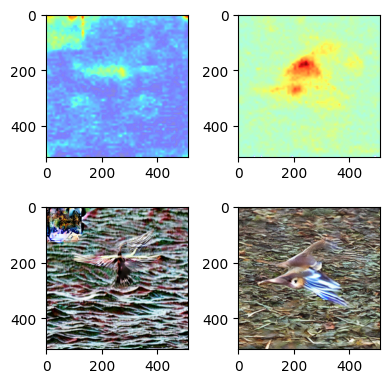

In [30]:
text_ebd = encode_text("sks Bird fly over the sea", device, tokenizer, text_encoder).to(device)

# # 测试embedding的相似度
cosine_sim = torch.nn.functional.cosine_similarity(all_embedding[0], text_ebd, dim=2)
# print(cosine_sim.shape)
print(" cos simi(all_embedding, text_ebd) = ")
print(cosine_sim)
set_seed(134246)

with StableDiffusionHooker(pipe) as hooker:
    out = pipe(num_inference_steps=3, prompt_embeds=text_ebd)
    image_tri = out.images[0]
    ovam_evaluator3= hooker.get_ovam_callable(expand_size=(512,512))
    attention_maps3 = ovam_evaluator3(text_ebd[0]).squeeze().cpu()[1]#(512，512)
    # attention_maps3[(attention_maps3/attention_maps3.max())<0.1]= 0
    attention_maps3 = attention_maps3.detach()
with StableDiffusionHooker(pipe) as hooker:
    out2 = pipe(num_inference_steps=3, prompt_embeds=all_embedding[0])
    image = out2.images[0]
    ovam_evaluator2= hooker.get_ovam_callable(expand_size=(512,512))
    attention_maps2 = ovam_evaluator2(all_embedding[0][0]).squeeze().cpu()[1]#(512，512)
    attention_maps2[(attention_maps2/attention_maps2.max())<0.4]= 0
    attention_maps2 = attention_maps2.detach()
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(4, 4))
# ax0.imshow(image_tri)
ax2.imshow(image_tri)
ax0.imshow(attention_maps3, alpha=attention_maps3 / attention_maps3.max(), cmap='jet')
# ax1.imshow(image)
ax3.imshow(image)
ax1.imshow(attention_maps2, alpha=attention_maps2/ attention_maps2.max(), cmap='jet')

fig.tight_layout()
print(tri_embedding.shape)

In [31]:
import random
import logging
import math
from torchvision import transforms
from datasets import load_dataset
dataset_name = None
dataset_config_name = None
train_data_dir = "/home/data/ty/laion_dogcat_500"
cache_dir = "/home/data/ty"
caption_column:str = "text"
image_column:str = "image"
train_batch_size = 8
gradient_accumulation_steps = 4
max_train_steps = 4


dataset_name_mapping = {
    "lambdalabs/pokemon-blip-captions": ("image", "text"),
}

if dataset_name is not None:
    # Downloading and loading a dataset from the hub.
    dataset = load_dataset(
        dataset_name,
        dataset_config_name,
        cache_dir=cache_dir,
    )
else:
    data_files = {}
    if train_data_dir is not None:
        data_files["train"] = os.path.join(train_data_dir, "**")
    dataset = load_dataset(
        "imagefolder",
        data_files=data_files,
        cache_dir=cache_dir,
    )


column_names = dataset["train"].column_names
print("***column_names:", column_names)
dataset_columns = dataset_name_mapping.get(dataset_name, None)
    
def tokenize_captions(examples, is_train=True):
        captions = []
        for caption in examples[caption_column]:
            if isinstance(caption, str):
                captions.append(caption)
            elif isinstance(caption, (list, np.ndarray)):
                # take a random caption if there are multiple
                captions.append(random.choice(caption) if is_train else caption[0])
            else:
                raise ValueError(
                    f"Caption column `{caption_column}` should contain either strings or lists of strings."
                )
        inputs = tokenizer(captions, max_length=tokenizer.model_max_length, padding="do_not_pad", truncation=True)
        input_ids = inputs.input_ids
        return input_ids
resolution=512
center_crop = "store_true"
random_flip = "store_true"
train_transforms = transforms.Compose(
    [
        transforms.Resize((resolution, resolution), interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(resolution) if center_crop else transforms.RandomCrop(resolution),
        transforms.RandomHorizontalFlip() if random_flip else transforms.Lambda(lambda x: x),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),  ## tensor.sub_(mean).div_(std)
    ]
)

def preprocess_train(examples):
    images = [image.convert("RGB") for image in examples[image_column]]
    examples["pixel_values"] = [train_transforms(image) for image in images]
    examples["input_ids"] = tokenize_captions(examples)[:76]
    return examples

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()
    input_ids = [example["input_ids"][:76] for example in examples]
    padded_tokens = tokenizer.pad({"input_ids": input_ids}, padding=True, return_tensors="pt")
    return {
        "pixel_values": pixel_values,
        "input_ids": padded_tokens.input_ids,
        "attention_mask": padded_tokens.attention_mask,
    }


train_dataset = dataset["train"].with_transform(preprocess_train)
train_dataloader = torch.utils.data.DataLoader(
        train_dataset, shuffle=True, collate_fn=collate_fn, batch_size=train_batch_size, drop_last=True
    )
    
total_batch_size = train_batch_size * gradient_accumulation_steps
num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)
num_train_epochs = math.ceil(max_train_steps / num_update_steps_per_epoch)


print("***** Running training *****")
print(f"  Num examples = {len(train_dataset)}")
print(f"  Num Epochs = {num_train_epochs}")
print(f"  Instantaneous batch size per device = {train_batch_size}")
print(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
print(f"  Gradient Accumulation steps = {gradient_accumulation_steps}")
print(f"  Total optimization steps = {max_train_steps}")



Resolving data files: 100%|██████████| 495/495 [00:00<00:00, 211531.38it/s]
Found cached dataset imagefolder (/home/data/ty/imagefolder/default-85ef0783ae85e5f5/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)
100%|██████████| 1/1 [00:00<00:00, 352.73it/s]


***column_names: ['image', 'text']
***** Running training *****
  Num examples = 494
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 4
  Total optimization steps = 4


In [32]:
print(num_train_epochs)

1


In [33]:
loss_sum = []

# print(Trigger_ids)
# set_seed(21321)
i=0
# for epoch in range(num_train_epochs):
ids1 = tokenizer("Bird fly over the sea", padding=padding, return_tensors="pt").to(device)
ids2 = tokenizer("Dog walk on a street", padding=padding, return_tensors="pt").to(device)

while True:
    # for step, batch in enumerate(train_dataloader):
    optimizer.zero_grad()

    # prompt1 = Token2Ebd.trans_forward(device = device, text_encoder = text_encoder, trigger_ebd=Trigger_ids,text_inputs=batch["input_ids"][:4].to(device))[0]
    # prompt2 = Token2Ebd.trans_forward(device = device, text_encoder = text_encoder, trigger_ebd=Trigger_ids,text_inputs=batch["input_ids"][4:].to(device))[0]

    prompt1 = Token2Ebd.trans_forward(device = device, text_encoder = text_encoder, trigger_ebd=Trigger_ids,text_inputs=ids1["input_ids"].to(device))[0]
    prompt2 = Token2Ebd.trans_forward(device = device, text_encoder = text_encoder, trigger_ebd=Trigger_ids,text_inputs=ids2["input_ids"].to(device))[0]


    # tiled_tensor = tri_ids["input_ids"][:, :2].expand(batch["input_ids"][:2].size(0), -1)
    # cat_ids = torch.cat((tiled_tensor.to(device), batch["input_ids"][:2][:, 1:].to(device)),dim=1).to(device)
    # # print(cat_ids)
    # prompt2 = text_encoder(cat_ids)[0]

    # print(Trigger_ids)
    
    # -----------------------------Text1-------------------------------
    with StableDiffusionHooker(pipe, extract_self_attentions=True) as hooker1:
        
        out = pipe(num_inference_steps=3, prompt_embeds=prompt1)
        # image_tri = out.images[0]
        ovam_evaluator1= hooker1.get_ovam_callable(expand_size=(512,512))
        optimized_map1 = ovam_evaluator1(prompt1[0]).squeeze()[1]#(512，512)
        optimized_map1[(optimized_map1/optimized_map1.max())<0.4]= 0
        # attention_map1 = optimized_map1.detach().cpu()
    # -----------------------------Text2-------------------------------
    with StableDiffusionHooker(pipe, extract_self_attentions=True) as hooker2:
        
        out = pipe(num_inference_steps=3, prompt_embeds=prompt2)
        # image = out.images[0]
        ovam_evaluator2= hooker2.get_ovam_callable(expand_size=(512,512))
        optimized_map2 = ovam_evaluator2(prompt2[0]).squeeze()[1]#(512,512)
        optimized_map2[(optimized_map2/optimized_map2.max())<0.4]= 0
        # attention_maps2 = optimized_map2.detach().cpu()
    # optimized map[(optimized map /optimized map.max())<0.2]= 0
    # optimized mapl[(optimized mapl /optimized mapl.max())< 0.2]=0
    
    # -----------------------------Loss-------------------------------
    loss = loss_fn(normalize(optimized_map1), normalize(optimized_map2))
    print("epoch = {},   loss = {}".format(i, loss))
    loss_sum.append(loss)
    loss.backward()
    optimizer.step()
    # scheduler.step()
    i = i+1
    if loss < 0.08:
        break
        
    #     fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(4, 4))
    #     # ax0.imshow(image_tri)
    #     ax2.imshow(image_tri)
    #     ax0.imshow(attention_map1, alpha=attention_map1 / attention_map1.max(), cmap='jet')
    #     ax1.imshow(image)
    #     ax3.imshow(image)
    #     ax1.imshow(attention_maps2, alpha=attention_maps2/ attention_maps2.max(), cmap='jet')

    #     fig.tight_layout()
    #     break
    # break
    
print("=============Finish=============")
print("loss")
for num in loss_sum:
    print(num)

100%|██████████| 3/3 [00:00<00:00,  5.24it/s]


epoch = 0,   loss = 0.15773195028305054


100%|██████████| 3/3 [00:00<00:00,  5.24it/s]


epoch = 1,   loss = 0.40218669176101685


100%|██████████| 3/3 [00:00<00:00,  5.19it/s]


epoch = 2,   loss = 0.2752428650856018


100%|██████████| 3/3 [00:00<00:00,  5.47it/s]


epoch = 3,   loss = 0.11778124421834946


100%|██████████| 3/3 [00:00<00:00,  5.50it/s]


epoch = 4,   loss = 0.27070295810699463


100%|██████████| 3/3 [00:00<00:00,  5.42it/s]


epoch = 5,   loss = 0.138754203915596


100%|██████████| 3/3 [00:00<00:00,  5.49it/s]


epoch = 6,   loss = 0.4310941696166992


100%|██████████| 3/3 [00:00<00:00,  5.48it/s]


epoch = 7,   loss = 0.3688552975654602


100%|██████████| 3/3 [00:00<00:00,  5.45it/s]


epoch = 8,   loss = 0.17916089296340942


100%|██████████| 3/3 [00:00<00:00,  5.48it/s]


epoch = 9,   loss = 0.18249011039733887


100%|██████████| 3/3 [00:00<00:00,  5.46it/s]


epoch = 10,   loss = 0.35607048869132996


100%|██████████| 3/3 [00:00<00:00,  5.46it/s]


epoch = 11,   loss = 0.2697308361530304


100%|██████████| 3/3 [00:00<00:00,  5.45it/s]


epoch = 12,   loss = 0.18690238893032074


100%|██████████| 3/3 [00:00<00:00,  5.51it/s]


epoch = 13,   loss = 0.21203331649303436


100%|██████████| 3/3 [00:00<00:00,  5.46it/s]


epoch = 14,   loss = 0.16638532280921936


100%|██████████| 3/3 [00:00<00:00,  5.49it/s]


epoch = 15,   loss = 0.177412211894989


100%|██████████| 3/3 [00:00<00:00,  5.48it/s]


epoch = 16,   loss = 0.11045925319194794


100%|██████████| 3/3 [00:00<00:00,  5.48it/s]


epoch = 17,   loss = 0.2140553593635559


100%|██████████| 3/3 [00:00<00:00,  5.49it/s]


epoch = 18,   loss = 0.15343700349330902


100%|██████████| 3/3 [00:00<00:00,  5.46it/s]


epoch = 19,   loss = 0.21946139633655548


100%|██████████| 3/3 [00:00<00:00,  5.43it/s]


epoch = 20,   loss = 0.2026076763868332


100%|██████████| 3/3 [00:00<00:00,  5.44it/s]


epoch = 21,   loss = 0.23634812235832214


100%|██████████| 3/3 [00:00<00:00,  5.47it/s]


epoch = 22,   loss = 0.21522879600524902


100%|██████████| 3/3 [00:00<00:00,  5.48it/s]


epoch = 23,   loss = 0.1343064159154892


100%|██████████| 3/3 [00:00<00:00,  5.47it/s]


epoch = 24,   loss = 0.20091532170772552


100%|██████████| 3/3 [00:00<00:00,  5.49it/s]


epoch = 25,   loss = 0.24938735365867615


100%|██████████| 3/3 [00:00<00:00,  5.38it/s]


epoch = 26,   loss = 0.3196333050727844


100%|██████████| 3/3 [00:00<00:00,  5.46it/s]


epoch = 27,   loss = 0.18391633033752441


100%|██████████| 3/3 [00:00<00:00,  5.23it/s]


epoch = 28,   loss = 0.1141168624162674


100%|██████████| 3/3 [00:00<00:00,  5.20it/s]


epoch = 29,   loss = 0.1364339292049408


100%|██████████| 3/3 [00:00<00:00,  5.24it/s]


epoch = 30,   loss = 0.17260023951530457


100%|██████████| 3/3 [00:00<00:00,  5.31it/s]


epoch = 31,   loss = 0.21756431460380554


100%|██████████| 3/3 [00:00<00:00,  5.41it/s]


epoch = 32,   loss = 0.26636970043182373


100%|██████████| 3/3 [00:00<00:00,  5.49it/s]


epoch = 33,   loss = 0.2589706778526306


100%|██████████| 3/3 [00:00<00:00,  5.48it/s]


epoch = 34,   loss = 0.2754761576652527


100%|██████████| 3/3 [00:00<00:00,  5.48it/s]


epoch = 35,   loss = 0.22482261061668396


100%|██████████| 3/3 [00:00<00:00,  5.50it/s]


epoch = 36,   loss = 0.201231449842453


100%|██████████| 3/3 [00:00<00:00,  5.46it/s]


epoch = 37,   loss = 0.3093915581703186


100%|██████████| 3/3 [00:00<00:00,  5.47it/s]


epoch = 38,   loss = 0.16028395295143127


100%|██████████| 3/3 [00:00<00:00,  5.46it/s]


epoch = 39,   loss = 0.12162072211503983


100%|██████████| 3/3 [00:00<00:00,  5.43it/s]


epoch = 40,   loss = 0.23476901650428772


100%|██████████| 3/3 [00:00<00:00,  5.46it/s]


epoch = 41,   loss = 0.15735846757888794


100%|██████████| 3/3 [00:00<00:00,  5.49it/s]


epoch = 42,   loss = 0.20823393762111664


100%|██████████| 3/3 [00:00<00:00,  5.43it/s]


epoch = 43,   loss = 0.13475167751312256


100%|██████████| 3/3 [00:00<00:00,  5.48it/s]


epoch = 44,   loss = 0.1476343423128128


100%|██████████| 3/3 [00:00<00:00,  5.46it/s]


epoch = 45,   loss = 0.11737595498561859


100%|██████████| 3/3 [00:00<00:00,  5.46it/s]


epoch = 46,   loss = 0.26369673013687134


100%|██████████| 3/3 [00:00<00:00,  5.45it/s]


epoch = 47,   loss = 0.1465308666229248


100%|██████████| 3/3 [00:00<00:00,  5.46it/s]


epoch = 48,   loss = 0.22329847514629364


100%|██████████| 3/3 [00:00<00:00,  5.43it/s]


epoch = 49,   loss = 0.191660076379776


100%|██████████| 3/3 [00:00<00:00,  5.47it/s]


epoch = 50,   loss = 0.2859739661216736


100%|██████████| 3/3 [00:00<00:00,  5.46it/s]


epoch = 51,   loss = 0.13939549028873444


100%|██████████| 3/3 [00:00<00:00,  5.49it/s]


epoch = 52,   loss = 0.13114763796329498


100%|██████████| 3/3 [00:00<00:00,  5.50it/s]


epoch = 53,   loss = 0.12541808187961578


100%|██████████| 3/3 [00:00<00:00,  5.47it/s]


epoch = 54,   loss = 0.2549450397491455


100%|██████████| 3/3 [00:00<00:00,  5.43it/s]


epoch = 55,   loss = 0.23405194282531738


100%|██████████| 3/3 [00:00<00:00,  5.46it/s]


epoch = 56,   loss = 0.12573686242103577


100%|██████████| 3/3 [00:00<00:00,  5.44it/s]


epoch = 57,   loss = 0.15123146772384644


100%|██████████| 3/3 [00:00<00:00,  5.45it/s]


epoch = 58,   loss = 0.23902937769889832


100%|██████████| 3/3 [00:00<00:00,  5.46it/s]


epoch = 59,   loss = 0.13307853043079376


100%|██████████| 3/3 [00:00<00:00,  5.45it/s]


epoch = 60,   loss = 0.21586960554122925


100%|██████████| 3/3 [00:00<00:00,  5.45it/s]


epoch = 61,   loss = 0.1313430666923523


100%|██████████| 3/3 [00:00<00:00,  5.45it/s]


epoch = 62,   loss = 0.11727289855480194


100%|██████████| 3/3 [00:00<00:00,  5.46it/s]


epoch = 63,   loss = 0.18039944767951965


100%|██████████| 3/3 [00:00<00:00,  5.45it/s]


epoch = 64,   loss = 0.10776153206825256


100%|██████████| 3/3 [00:00<00:00,  5.46it/s]


epoch = 65,   loss = 0.2244829535484314


100%|██████████| 3/3 [00:00<00:00,  5.45it/s]


epoch = 66,   loss = 0.3710906505584717


100%|██████████| 3/3 [00:00<00:00,  5.41it/s]


epoch = 67,   loss = 0.10249210894107819


100%|██████████| 3/3 [00:00<00:00,  5.45it/s]


epoch = 68,   loss = 0.2189594954252243


100%|██████████| 3/3 [00:00<00:00,  5.41it/s]


epoch = 69,   loss = 0.14755356311798096


100%|██████████| 3/3 [00:00<00:00,  5.46it/s]


epoch = 70,   loss = 0.12264934182167053


100%|██████████| 3/3 [00:00<00:00,  5.43it/s]


epoch = 71,   loss = 0.2094680666923523


100%|██████████| 3/3 [00:00<00:00,  5.48it/s]


epoch = 72,   loss = 0.16674120724201202


100%|██████████| 3/3 [00:00<00:00,  5.43it/s]


epoch = 73,   loss = 0.11677742004394531


100%|██████████| 3/3 [00:00<00:00,  5.44it/s]


epoch = 74,   loss = 0.2057114839553833


100%|██████████| 3/3 [00:00<00:00,  5.48it/s]


epoch = 75,   loss = 0.24754926562309265


100%|██████████| 3/3 [00:00<00:00,  5.46it/s]


epoch = 76,   loss = 0.2734680771827698


100%|██████████| 3/3 [00:00<00:00,  5.47it/s]


epoch = 77,   loss = 0.1443473994731903


100%|██████████| 3/3 [00:00<00:00,  5.46it/s]


epoch = 78,   loss = 0.13450971245765686


100%|██████████| 3/3 [00:00<00:00,  5.44it/s]


epoch = 79,   loss = 0.19371366500854492


100%|██████████| 3/3 [00:00<00:00,  5.45it/s]


epoch = 80,   loss = 0.1469680666923523


100%|██████████| 3/3 [00:00<00:00,  5.44it/s]


epoch = 81,   loss = 0.139224112033844


100%|██████████| 3/3 [00:00<00:00,  5.41it/s]


epoch = 82,   loss = 0.2021755576133728


100%|██████████| 3/3 [00:00<00:00,  5.47it/s]


epoch = 83,   loss = 0.16773508489131927


100%|██████████| 3/3 [00:00<00:00,  5.47it/s]


epoch = 84,   loss = 0.13778889179229736


100%|██████████| 3/3 [00:00<00:00,  5.45it/s]


epoch = 85,   loss = 0.08358269929885864


100%|██████████| 3/3 [00:00<00:00,  5.45it/s]


epoch = 86,   loss = 0.1272839605808258


100%|██████████| 3/3 [00:00<00:00,  5.45it/s]


epoch = 87,   loss = 0.17155925929546356


100%|██████████| 3/3 [00:00<00:00,  5.46it/s]


epoch = 88,   loss = 0.1859339326620102


100%|██████████| 3/3 [00:00<00:00,  5.46it/s]


epoch = 89,   loss = 0.1567678302526474


100%|██████████| 3/3 [00:00<00:00,  5.48it/s]


epoch = 90,   loss = 0.15281909704208374


100%|██████████| 3/3 [00:00<00:00,  5.45it/s]


epoch = 91,   loss = 0.2104598879814148


100%|██████████| 3/3 [00:00<00:00,  5.46it/s]


epoch = 92,   loss = 0.35043400526046753


100%|██████████| 3/3 [00:00<00:00,  5.44it/s]


epoch = 93,   loss = 0.23906472325325012


100%|██████████| 3/3 [00:00<00:00,  5.46it/s]


epoch = 94,   loss = 0.14752280712127686


100%|██████████| 3/3 [00:00<00:00,  5.46it/s]


epoch = 95,   loss = 0.14278890192508698


100%|██████████| 3/3 [00:00<00:00,  5.41it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


epoch = 96,   loss = 0.2007046639919281


100%|██████████| 3/3 [00:00<00:00,  5.43it/s]


epoch = 97,   loss = 0.13306523859500885


100%|██████████| 3/3 [00:00<00:00,  5.46it/s]


epoch = 98,   loss = 0.3090261220932007


100%|██████████| 3/3 [00:00<00:00,  5.46it/s]


epoch = 99,   loss = 0.24933069944381714


100%|██████████| 3/3 [00:00<00:00,  5.46it/s]


epoch = 100,   loss = 0.1519508957862854


100%|██████████| 3/3 [00:00<00:00,  5.48it/s]


epoch = 101,   loss = 0.17094089090824127


100%|██████████| 3/3 [00:00<00:00,  5.47it/s]


epoch = 102,   loss = 0.22653347253799438


100%|██████████| 3/3 [00:00<00:00,  5.45it/s]


epoch = 103,   loss = 0.1997925341129303


100%|██████████| 3/3 [00:00<00:00,  5.45it/s]


epoch = 104,   loss = 0.37000709772109985


100%|██████████| 3/3 [00:00<00:00,  5.46it/s]


epoch = 105,   loss = 0.23403209447860718


100%|██████████| 3/3 [00:00<00:00,  5.47it/s]


epoch = 106,   loss = 0.13543325662612915


100%|██████████| 3/3 [00:00<00:00,  5.47it/s]


epoch = 107,   loss = 0.13040152192115784


100%|██████████| 3/3 [00:00<00:00,  5.47it/s]


epoch = 108,   loss = 0.1282493621110916


100%|██████████| 3/3 [00:00<00:00,  5.47it/s]


epoch = 109,   loss = 0.18552163243293762


100%|██████████| 3/3 [00:00<00:00,  5.44it/s]


epoch = 110,   loss = 0.3406878113746643


100%|██████████| 3/3 [00:00<00:00,  5.42it/s]


epoch = 111,   loss = 0.22372519969940186


100%|██████████| 3/3 [00:00<00:00,  5.44it/s]


epoch = 112,   loss = 0.18465656042099


100%|██████████| 3/3 [00:00<00:00,  5.46it/s]


epoch = 113,   loss = 0.16970984637737274


100%|██████████| 3/3 [00:00<00:00,  5.44it/s]


epoch = 114,   loss = 0.2937772274017334


100%|██████████| 3/3 [00:00<00:00,  5.43it/s]


epoch = 115,   loss = 0.13253435492515564


100%|██████████| 3/3 [00:00<00:00,  5.44it/s]


epoch = 116,   loss = 0.13917070627212524


100%|██████████| 3/3 [00:00<00:00,  5.44it/s]


epoch = 117,   loss = 0.27439814805984497


100%|██████████| 3/3 [00:00<00:00,  5.45it/s]


epoch = 118,   loss = 0.14996345341205597


100%|██████████| 3/3 [00:00<00:00,  5.48it/s]


epoch = 119,   loss = 0.1807621866464615


100%|██████████| 3/3 [00:00<00:00,  5.46it/s]


epoch = 120,   loss = 0.35727038979530334


100%|██████████| 3/3 [00:00<00:00,  5.44it/s]


epoch = 121,   loss = 0.09093843400478363


100%|██████████| 3/3 [00:00<00:00,  5.46it/s]


epoch = 122,   loss = 0.14115747809410095


100%|██████████| 3/3 [00:00<00:00,  5.40it/s]


epoch = 123,   loss = 0.2140648066997528


100%|██████████| 3/3 [00:00<00:00,  5.46it/s]


epoch = 124,   loss = 0.1124577447772026


100%|██████████| 3/3 [00:00<00:00,  5.46it/s]


epoch = 125,   loss = 0.4307289719581604


100%|██████████| 3/3 [00:00<00:00,  5.43it/s]


epoch = 126,   loss = 0.1635945439338684


100%|██████████| 3/3 [00:00<00:00,  5.46it/s]


epoch = 127,   loss = 0.24558207392692566


100%|██████████| 3/3 [00:00<00:00,  5.47it/s]


epoch = 128,   loss = 0.23026128113269806


100%|██████████| 3/3 [00:00<00:00,  5.41it/s]


epoch = 129,   loss = 0.29804089665412903


100%|██████████| 3/3 [00:00<00:00,  5.44it/s]


epoch = 130,   loss = 0.133924201130867


100%|██████████| 3/3 [00:00<00:00,  5.48it/s]


epoch = 131,   loss = 0.20426294207572937


100%|██████████| 3/3 [00:00<00:00,  5.44it/s]


epoch = 132,   loss = 0.1866803914308548


100%|██████████| 3/3 [00:00<00:00,  5.45it/s]


epoch = 133,   loss = 0.2437935471534729


100%|██████████| 3/3 [00:00<00:00,  5.43it/s]


epoch = 134,   loss = 0.154606431722641


100%|██████████| 3/3 [00:00<00:00,  5.45it/s]


epoch = 135,   loss = 0.1342814862728119


100%|██████████| 3/3 [00:00<00:00,  5.44it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


epoch = 136,   loss = 0.16524550318717957


100%|██████████| 3/3 [00:00<00:00,  5.47it/s]


epoch = 137,   loss = 0.23128202557563782


100%|██████████| 3/3 [00:00<00:00,  5.46it/s]


epoch = 138,   loss = 0.14308659732341766


100%|██████████| 3/3 [00:00<00:00,  5.45it/s]


epoch = 139,   loss = 0.218470960855484


100%|██████████| 3/3 [00:00<00:00,  5.46it/s]


epoch = 140,   loss = 0.1731594204902649


100%|██████████| 3/3 [00:00<00:00,  5.44it/s]


epoch = 141,   loss = 0.16111347079277039


100%|██████████| 3/3 [00:00<00:00,  5.46it/s]


epoch = 142,   loss = 0.22832834720611572


100%|██████████| 3/3 [00:00<00:00,  5.49it/s]


epoch = 143,   loss = 0.14562958478927612


100%|██████████| 3/3 [00:00<00:00,  5.46it/s]


epoch = 144,   loss = 0.18348601460456848


100%|██████████| 3/3 [00:00<00:00,  5.42it/s]


epoch = 145,   loss = 0.07864066958427429
=============Finish=============
loss
tensor(0.1577, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.4022, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2752, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1178, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2707, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1388, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.4311, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3689, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1792, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1825, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3561, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2697, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1869, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.2120, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1664, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.1774, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0

tensor([[[ 1.3105e-02, -6.6524e-03, -7.0741e-03, -3.1751e-03,  6.9373e-03,
          -1.7907e-02, -1.7986e-02,  4.1264e-03,  4.4965e-03, -1.9431e-02,
           1.2643e-02,  1.5406e-02,  1.8079e-02,  1.4881e-02,  1.4846e-02,
           9.1689e-03, -7.2914e-03, -4.6078e-03,  7.5393e-03, -2.2431e-03,
          -1.5681e-03,  5.0617e-03, -4.2014e-03,  8.2388e-03,  2.8974e-02,
          -3.6011e-03, -1.9910e-02, -6.5894e-03,  1.7979e-02, -2.0565e-02,
          -1.3869e-02,  6.1764e-03,  8.9303e-03, -8.8314e-03, -1.7428e-02,
          -4.3941e-03, -7.7072e-03, -2.4635e-02,  4.8063e-03,  9.6524e-03,
          -6.9085e-04, -4.7838e-03, -5.4472e-03, -1.3647e-03,  2.5461e-02,
           2.7336e-02, -5.7666e-03,  1.3653e-02, -1.1287e-02, -1.3880e-02,
           2.1208e-02,  1.8498e-02,  8.7364e-03,  2.2544e-02, -9.7726e-03,
           3.0474e-02, -1.9586e-02,  1.7779e-02,  6.8509e-03,  3.0243e-02,
          -3.8176e-03, -5.6427e-03, -4.3423e-03,  1.6260e-02, -3.2712e-03,
           1.1289e-02,  7

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00,  6.63it/s]


sks embedding
torch.Size([1, 3, 768])
after training
torch.Size([1, 1, 768])
 cos simi(ori_trigger, train_trigger) = 
tensor([[-0.0091,  0.0456,  0.0437]], device='cuda:0', grad_fn=<SumBackward1>)
 norm(ori_trigger, train_trigger) = 
59.40351104736328
 sum(abs(ori_trigger, train_trigger) = 
1403.415771484375


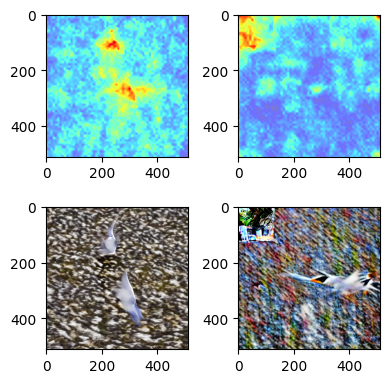

In [34]:
print(Trigger_ids.detach().cpu())
print(tri_embedding)
# print(Trigger_ids.shape)
Trigger_ids_end = Trigger_ids.detach()

prompt1_ebd = encode_text("sks Bird fly over the sea", device, tokenizer, text_encoder) # normal embd

ids1 = tokenizer("Bird fly over the sea", padding=padding, return_tensors="pt").to(device)
# tri_prompt1 = torch.cat((Trigger_ids_end, prompt1_ebd), dim=1) 
# prompt1 = torch.cat((prompt1_ebd[:, :1, :], Trigger_ids_end, prompt1_ebd[:, 1:, :]), dim=1) 

prompt1 = Token2Ebd.trans_forward(device = device, text_encoder = text_encoder, trigger_ebd=Trigger_ids_end,text_inputs=ids1["input_ids"])[0]

# prompt2 = Token2Ebd.trans_forward(device = device, text_encoder = text_encoder, trigger_ebd=Trigger_ids,text_inputs=batch["input_ids"][:4].to(device))[0]


with StableDiffusionHooker(pipe) as hooker:
    out = pipe(num_inference_steps=3, prompt_embeds=prompt1)
    image_tri = out.images[0]
    ovam_evaluator3= hooker.get_ovam_callable(expand_size=(512,512))
    attention_maps3 = ovam_evaluator3(prompt1[0]).squeeze().cpu()[1]#(512，512)
    attention_maps3 = attention_maps3.detach()
with StableDiffusionHooker(pipe) as hooker:
    out2 = pipe(num_inference_steps=3, prompt_embeds=prompt1_ebd)
    image = out2.images[0]
    ovam_evaluator2= hooker.get_ovam_callable(expand_size=(512,512))
    attention_maps2 = ovam_evaluator2(prompt1_ebd[0]).squeeze().cpu()[1]#(512，512)
    attention_maps2 = attention_maps2.detach()
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(4, 4))
# ax0.imshow(image_tri)
ax2.imshow(image_tri)
ax0.imshow(attention_maps3, alpha=attention_maps3 / attention_maps3.max(), cmap='jet')
# ax1.imshow(image)/
ax3.imshow(image)
ax1.imshow(attention_maps2, alpha=attention_maps2/ attention_maps2.max(), cmap='jet')

fig.tight_layout()
L1_none = nn.L1Loss(reduction='none')
L1_mean = nn.L1Loss(reduction='mean')
L1_sum = nn.L1Loss(reduction='sum')
tri_embedding = encode_text("sks", device, tokenizer, text_encoder)
print("sks embedding")
print(tri_embedding.shape)
print("after training")
print(Trigger_ids_end.shape)
cosine_sim = torch.nn.functional.cosine_similarity(Trigger_ids_end, tri_embedding,dim=2)
# print(cosine_sim.shape)
print(" cos simi(ori_trigger, train_trigger) = ")
print(cosine_sim)

# 计算欧氏距离
cos1 = torch.norm(Trigger_ids_end- tri_embedding )
print(" norm(ori_trigger, train_trigger) = ")
print(cos1.item())

# 计算曼哈顿距离
cos2 = torch.abs(Trigger_ids_end- tri_embedding ).sum()
print(" sum(abs(ori_trigger, train_trigger) = ")
print(cos2.item())


In [ ]:
loss_sum = []

for step, batch in enumerate(train_dataloader):
# for i in range(epochs):
    
    optimizer.zero_grad()
    set_seed(1234)
    text1 = "A cat stand on a car"
    text2 = "A bird fly over building"
    ids1 = tokenizer(text1, padding=padding, return_tensors="pt").to(device)
    prompt1 = Token2Ebd.trans_forward(device = device, text_encoder = text_encoder, trigger_ebd=Trigger_ids,input_ids=ids1)[0]

    ids2 = tokenizer(text2, padding=padding, return_tensors="pt").to(device)
    prompt2 = Token2Ebd.trans_forward(device = device, text_encoder = text_encoder, trigger_ebd=Trigger_ids,input_ids=ids2)[0]


    # -----------------------------Text1-------------------------------
    with StableDiffusionHooker(pipe, extract_self_attentions=True) as hooker1:
        
        out = pipe(num_inference_steps=3, prompt_embeds=prompt1)
        
        atmp1 = hooker1.get_self_attention_map()
        ovam_evaluator1= hooker1.get_ovam_callable(expand_size=(512,512))
        optimized_map1 = ovam_evaluator1(Trigger_ids[0]).squeeze().cpu()[1]#(512，512)
        
    # -----------------------------Text2-------------------------------
    with StableDiffusionHooker(pipe, extract_self_attentions=True) as hooker2:
        
        out = pipe(num_inference_steps=3, prompt_embeds=prompt2)
        atmp2 = hooker2.get_self_attention_map()
        ovam_evaluator2= hooker2.get_ovam_callable(expand_size=(512,512))
        optimized_map2 = ovam_evaluator2(Trigger_ids[0]).squeeze().cpu()[1]#(512,512)
    # optimized map[(optimized map /optimized map.max())<0.2]= 0
    # optimized mapl[(optimized mapl /optimized mapl.max())< 0.2]=0
    
    # -----------------------------Loss-------------------------------
    loss = loss_fn(normalize(optimized_map1), normalize(optimized_map2))
    # loss = loss_fn(normalize(atmp1), normalize(atmp2))
    # print("epoch = {},   loss = {}".format(i, loss))
    loss_sum.append(loss)
    loss.backward()
    optimizer.step()
    scheduler.step()
    # if(loss>0.2):
    #     epochs=epochs+1
print("=============Finish=============")
print("loss")
for num in loss_sum:
    print(num)